In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ['THEANO_FLAGS'] = 'device=gpu'
from keras.layers import *
from keras.models import Model
from sklearn.datasets import  load_digits
from keras.optimizers import Adam, RMSprop, SGD
import theano.tensor as T

Using Theano backend.
Using gpu device 0: Tesla K20Xm (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)

Couldn't import dot_parser, loading of dot files will not be possible.


In [5]:
data = load_digits()
y = data['target']
data = data['data']
data = data.astype(np.float32)
data /= data.max()
F = data.shape[1]
z = np.zeros((data.shape[0], data.shape[1]+2))
z[:, 0:F] = data
z = z.astype(np.float32)
#x =- x.min()
#x /= x.max()

In [49]:
def euclidean_dist(X):
    s = (X.dimshuffle(0, 1, 'x') - X.dimshuffle('x', 1, 0)) ** 2
    return (s.sum(axis=1))

def gaussian_dist(X):
    sigma = 5
    a, b = X.dimshuffle(0, 1, 'x'), X.dimshuffle('x', 1, 0) # (N, F, 1) (1, F, N) ==> N, F, N
    d = ((a-b)**2).sum(axis=1) # N, N 
    d = T.exp(-d / (2 * sigma**2))
    d = d * (1 - T.eye(d.shape[0]))
    d = d / (d.sum(axis=1, keepdims=True) - 1)
    return 0.5 * (d + d.T)

def student_dist(X):
    alpha = 15
    a, b = X.dimshuffle(0, 1, 'x'), X.dimshuffle('x', 1, 0) # (N, F, 1) (1, F, N) ==> N, F, N
    d = (((a-b)**2).sum(axis=1)) # N, N
    d = d * (1 - T.eye(d.shape[0]))
    d = (1 + d / alpha) ** (-(alpha + 1) * 0.5)#N,M
    d = d / (d.sum(keepdims=True))
    return d

def mse(x, y):
    return ((x-y)**2).mean()

def kl(p, q):
    return (-p * T.log(q)).sum()


pairwise_dist = student_dist
objective = kl

def loss_function(otrue, opred):
    zpred = opred[:, F:]
    xtrue = opred[:, 0:F]
    return objective(student_dist(xtrue), student_dist(zpred))



x = Input(shape=(F,))
inp = x
x = Dense(100)(x)
x = Activation('relu')(x)
x = Dense(50)(x)
x = Activation('relu')(x)
x = Dense(2)(x)
outp = merge([inp, x], mode='concat', concat_axis=1)
model = Model(input=inp, output=outp)
optimizer = SGD(lr=0.001, momentum=0.9, nesterov=True)
#optimizer = Adam(lr=0.0001)
#optimizer = RMSprop(lr=0.001)
model.compile(loss=loss_function, optimizer=optimizer)

In [50]:
model.fit(data, z, nb_epoch=100, batch_size=2048, shuffle=True, verbose=False)

/home/mcherti/build/keras/keras/backend/theano_backend.py:514: UserWarning: theano.function was asked to create a function computing outputs given certain inputs, but the provided input variable at index 1 is not part of the computational graph needed to compute the outputs: merge_9_target.
To make this warning into an error, you can pass the parameter on_unused_input='raise' to theano.function. To disable it completely, use on_unused_input='ignore'.
  **kwargs)


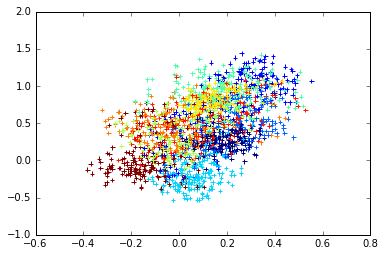

In [48]:
coords = model.predict(data)[:, F:]
plt.scatter(coords[:, 0], coords[:, 1], c=y, marker='+')

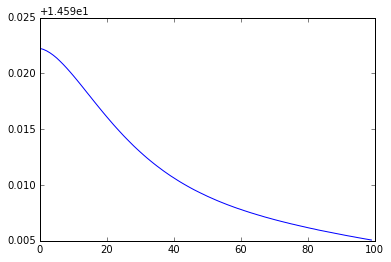

In [31]:
plt.plot(model.history.history['loss'])

In [38]:
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score

In [36]:
coords = TSNE().fit_transform(data)

NameError: name 'cross_val_score' is not defined

In [41]:
print(cross_val_score(RandomForestClassifier(), data, y))
print(cross_val_score(RandomForestClassifier(), coords, y))
print(cross_val_score(RandomForestClassifier(), model.predict(data)[:, F:], y))

[ 0.89368771  0.92821369  0.89261745]
[ 0.96179402  0.96327212  0.96812081]
[ 0.49667774  0.52754591  0.53187919]


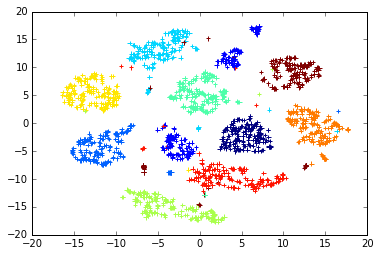

In [34]:
plt.scatter(coords[:, 0], coords[:, 1], c=y, marker='+')